In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 525], examples_per_second: 731.9109, train_label_loss: 2.7979, 


epoch: 1, [batch: 53 / 525], examples_per_second: 10614.1068, train_label_loss: 2.6464, 


epoch: 1, [batch: 105 / 525], examples_per_second: 10808.5008, train_label_loss: 2.3375, 


epoch: 1, [batch: 158 / 525], examples_per_second: 10675.6085, train_label_loss: 2.2389, 


epoch: 1, [batch: 210 / 525], examples_per_second: 10716.9941, train_label_loss: 2.0481, 


epoch: 1, [batch: 263 / 525], examples_per_second: 10585.0022, train_label_loss: 1.8372, 


epoch: 1, [batch: 315 / 525], examples_per_second: 10718.0310, train_label_loss: 1.8146, 


epoch: 1, [batch: 367 / 525], examples_per_second: 10749.4121, train_label_loss: 1.6465, 


epoch: 1, [batch: 420 / 525], examples_per_second: 10771.0728, train_label_loss: 1.6328, 


epoch: 1, [batch: 472 / 525], examples_per_second: 10600.8507, train_label_loss: 1.6009, 


epoch: 1, source_val_acc_label: 0.5138, source_val_label_loss: 1.4567, target_val_acc_label: 0.0667, target_val_label_loss: 6.2069, 


New best
epoch: 2, [batch: 1 / 525], examples_per_second: 104.5498, train_label_loss: 1.3046, 


epoch: 2, [batch: 53 / 525], examples_per_second: 11814.1659, train_label_loss: 1.2228, 


epoch: 2, [batch: 105 / 525], examples_per_second: 11655.0227, train_label_loss: 1.1509, 


epoch: 2, [batch: 158 / 525], examples_per_second: 11671.3509, train_label_loss: 1.1304, 


epoch: 2, [batch: 210 / 525], examples_per_second: 11484.8194, train_label_loss: 0.9795, 


epoch: 2, [batch: 263 / 525], examples_per_second: 11726.1640, train_label_loss: 0.8238, 


epoch: 2, [batch: 315 / 525], examples_per_second: 11899.5107, train_label_loss: 0.7660, 


epoch: 2, [batch: 367 / 525], examples_per_second: 11635.5871, train_label_loss: 0.6930, 


epoch: 2, [batch: 420 / 525], examples_per_second: 11621.4273, train_label_loss: 0.8772, 


epoch: 2, [batch: 472 / 525], examples_per_second: 11724.7505, train_label_loss: 0.7346, 


epoch: 2, source_val_acc_label: 0.8590, source_val_label_loss: 0.6315, target_val_acc_label: 0.0684, target_val_label_loss: 11.0671, 


New best
epoch: 3, [batch: 1 / 525], examples_per_second: 138.1315, train_label_loss: 0.5583, 


epoch: 3, [batch: 53 / 525], examples_per_second: 11634.9519, train_label_loss: 0.7111, 


epoch: 3, [batch: 105 / 525], examples_per_second: 11722.3381, train_label_loss: 0.5805, 


epoch: 3, [batch: 158 / 525], examples_per_second: 11779.2020, train_label_loss: 0.4759, 


epoch: 3, [batch: 210 / 525], examples_per_second: 11840.9542, train_label_loss: 0.5033, 


epoch: 3, [batch: 263 / 525], examples_per_second: 11776.1502, train_label_loss: 0.4979, 


epoch: 3, [batch: 315 / 525], examples_per_second: 11809.5131, train_label_loss: 0.5764, 


epoch: 3, [batch: 367 / 525], examples_per_second: 11792.2734, train_label_loss: 0.4045, 


epoch: 3, [batch: 420 / 525], examples_per_second: 11838.3736, train_label_loss: 0.4161, 


epoch: 3, [batch: 472 / 525], examples_per_second: 11876.8918, train_label_loss: 0.3653, 


epoch: 3, source_val_acc_label: 0.9361, source_val_label_loss: 0.3672, target_val_acc_label: 0.0746, target_val_label_loss: 29.1528, 


New best
epoch: 4, [batch: 1 / 525], examples_per_second: 143.7565, train_label_loss: 0.3767, 


epoch: 4, [batch: 53 / 525], examples_per_second: 11403.0540, train_label_loss: 0.3829, 


epoch: 4, [batch: 105 / 525], examples_per_second: 11669.9213, train_label_loss: 0.3224, 


epoch: 4, [batch: 158 / 525], examples_per_second: 11679.2602, train_label_loss: 0.3150, 


epoch: 4, [batch: 210 / 525], examples_per_second: 11805.7725, train_label_loss: 0.3337, 


epoch: 4, [batch: 263 / 525], examples_per_second: 11830.7786, train_label_loss: 0.3717, 


epoch: 4, [batch: 315 / 525], examples_per_second: 11703.6686, train_label_loss: 0.4358, 


epoch: 4, [batch: 367 / 525], examples_per_second: 11734.7995, train_label_loss: 0.2562, 


epoch: 4, [batch: 420 / 525], examples_per_second: 11802.2629, train_label_loss: 0.2446, 


epoch: 4, [batch: 472 / 525], examples_per_second: 11800.5028, train_label_loss: 0.3472, 


epoch: 4, source_val_acc_label: 0.9122, source_val_label_loss: 0.3644, target_val_acc_label: 0.0713, target_val_label_loss: 15.3340, 


epoch: 5, [batch: 1 / 525], examples_per_second: 143.0274, train_label_loss: 0.2589, 


epoch: 5, [batch: 53 / 525], examples_per_second: 11766.8849, train_label_loss: 0.2735, 


epoch: 5, [batch: 105 / 525], examples_per_second: 11840.6679, train_label_loss: 0.2904, 


epoch: 5, [batch: 158 / 525], examples_per_second: 11817.3207, train_label_loss: 0.2107, 


epoch: 5, [batch: 210 / 525], examples_per_second: 11769.3603, train_label_loss: 0.2484, 


epoch: 5, [batch: 263 / 525], examples_per_second: 11896.4613, train_label_loss: 0.2781, 


epoch: 5, [batch: 315 / 525], examples_per_second: 11443.8281, train_label_loss: 0.3676, 


epoch: 5, [batch: 367 / 525], examples_per_second: 11664.1385, train_label_loss: 0.2330, 


epoch: 5, [batch: 420 / 525], examples_per_second: 11861.5780, train_label_loss: 0.2325, 


epoch: 5, [batch: 472 / 525], examples_per_second: 11691.0285, train_label_loss: 0.1820, 


epoch: 5, source_val_acc_label: 0.9457, source_val_label_loss: 0.2383, target_val_acc_label: 0.0713, target_val_label_loss: 22.0369, 


epoch: 6, [batch: 1 / 525], examples_per_second: 142.2735, train_label_loss: 0.1860, 


epoch: 6, [batch: 53 / 525], examples_per_second: 11727.4889, train_label_loss: 0.2041, 


epoch: 6, [batch: 105 / 525], examples_per_second: 11810.6672, train_label_loss: 0.1644, 


epoch: 6, [batch: 158 / 525], examples_per_second: 11948.6708, train_label_loss: 0.1787, 


epoch: 6, [batch: 210 / 525], examples_per_second: 11752.5541, train_label_loss: 0.2010, 


epoch: 6, [batch: 263 / 525], examples_per_second: 11889.8846, train_label_loss: 0.2258, 


epoch: 6, [batch: 315 / 525], examples_per_second: 11865.5641, train_label_loss: 0.2345, 


epoch: 6, [batch: 367 / 525], examples_per_second: 11779.3120, train_label_loss: 0.2532, 


epoch: 6, [batch: 420 / 525], examples_per_second: 11865.6341, train_label_loss: 0.4273, 


epoch: 6, [batch: 472 / 525], examples_per_second: 11762.6261, train_label_loss: 0.2218, 


epoch: 6, source_val_acc_label: 0.9493, source_val_label_loss: 0.2637, target_val_acc_label: 0.0723, target_val_label_loss: 69.1165, 


epoch: 7, [batch: 1 / 525], examples_per_second: 144.7286, train_label_loss: 0.1913, 


epoch: 7, [batch: 53 / 525], examples_per_second: 12646.4998, train_label_loss: 0.2151, 


epoch: 7, [batch: 105 / 525], examples_per_second: 12479.9673, train_label_loss: 0.1949, 


epoch: 7, [batch: 158 / 525], examples_per_second: 12747.7534, train_label_loss: 0.1762, 


epoch: 7, [batch: 210 / 525], examples_per_second: 12796.7441, train_label_loss: 0.1962, 


epoch: 7, [batch: 263 / 525], examples_per_second: 12168.5291, train_label_loss: 0.1995, 


epoch: 7, [batch: 315 / 525], examples_per_second: 10796.6545, train_label_loss: 0.1461, 


epoch: 7, [batch: 367 / 525], examples_per_second: 10773.6800, train_label_loss: 0.1293, 


epoch: 7, [batch: 420 / 525], examples_per_second: 10930.5886, train_label_loss: 0.2137, 


epoch: 7, [batch: 472 / 525], examples_per_second: 10809.2624, train_label_loss: 0.2407, 


epoch: 7, source_val_acc_label: 0.9300, source_val_label_loss: 0.2441, target_val_acc_label: 0.0811, target_val_label_loss: 42.9925, 


New best
epoch: 8, [batch: 1 / 525], examples_per_second: 118.4135, train_label_loss: 0.1809, 


epoch: 8, [batch: 53 / 525], examples_per_second: 10740.4132, train_label_loss: 0.1532, 


epoch: 8, [batch: 105 / 525], examples_per_second: 10744.3070, train_label_loss: 0.1234, 


epoch: 8, [batch: 158 / 525], examples_per_second: 10719.9952, train_label_loss: 0.1300, 


epoch: 8, [batch: 210 / 525], examples_per_second: 10728.3734, train_label_loss: 0.1252, 


epoch: 8, [batch: 263 / 525], examples_per_second: 10815.2349, train_label_loss: 0.0992, 


epoch: 8, [batch: 315 / 525], examples_per_second: 10716.5663, train_label_loss: 0.1224, 


epoch: 8, [batch: 367 / 525], examples_per_second: 10774.8151, train_label_loss: 0.1634, 


epoch: 8, [batch: 420 / 525], examples_per_second: 10670.5361, train_label_loss: 0.1711, 


epoch: 8, [batch: 472 / 525], examples_per_second: 10782.9472, train_label_loss: 0.2270, 


epoch: 8, source_val_acc_label: 0.9593, source_val_label_loss: 0.1729, target_val_acc_label: 0.0757, target_val_label_loss: 45.8578, 


epoch: 9, [batch: 1 / 525], examples_per_second: 122.9527, train_label_loss: 0.1219, 


epoch: 9, [batch: 53 / 525], examples_per_second: 10798.6466, train_label_loss: 0.1866, 


epoch: 9, [batch: 105 / 525], examples_per_second: 10766.4961, train_label_loss: 0.0982, 


epoch: 9, [batch: 158 / 525], examples_per_second: 10757.1464, train_label_loss: 0.1857, 


epoch: 9, [batch: 210 / 525], examples_per_second: 10792.4640, train_label_loss: 0.0895, 


epoch: 9, [batch: 263 / 525], examples_per_second: 10745.3049, train_label_loss: 0.1380, 


epoch: 9, [batch: 315 / 525], examples_per_second: 10732.0110, train_label_loss: 0.1390, 


epoch: 9, [batch: 367 / 525], examples_per_second: 10837.0735, train_label_loss: 0.2035, 


epoch: 9, [batch: 420 / 525], examples_per_second: 10703.9210, train_label_loss: 0.1731, 


epoch: 9, [batch: 472 / 525], examples_per_second: 10601.3298, train_label_loss: 0.1277, 


epoch: 9, source_val_acc_label: 0.9289, source_val_label_loss: 0.2570, target_val_acc_label: 0.0841, target_val_label_loss: 49.2576, 


New best
epoch: 10, [batch: 1 / 525], examples_per_second: 117.8861, train_label_loss: 0.1463, 


epoch: 10, [batch: 53 / 525], examples_per_second: 10749.5570, train_label_loss: 0.1356, 


epoch: 10, [batch: 105 / 525], examples_per_second: 10777.4565, train_label_loss: 0.1726, 


epoch: 10, [batch: 158 / 525], examples_per_second: 10613.2077, train_label_loss: 0.1132, 


epoch: 10, [batch: 210 / 525], examples_per_second: 10735.1473, train_label_loss: 0.1218, 


epoch: 10, [batch: 263 / 525], examples_per_second: 10647.1983, train_label_loss: 0.2243, 


epoch: 10, [batch: 315 / 525], examples_per_second: 10818.0082, train_label_loss: 0.1570, 


epoch: 10, [batch: 367 / 525], examples_per_second: 10792.4640, train_label_loss: 0.0987, 


epoch: 10, [batch: 420 / 525], examples_per_second: 10803.2406, train_label_loss: 0.1323, 


epoch: 10, [batch: 472 / 525], examples_per_second: 10768.2444, train_label_loss: 0.1295, 


epoch: 10, source_val_acc_label: 0.9513, source_val_label_loss: 0.2593, target_val_acc_label: 0.0763, target_val_label_loss: 60.4612, 


epoch: 11, [batch: 1 / 525], examples_per_second: 122.2520, train_label_loss: 0.1075, 


epoch: 11, [batch: 53 / 525], examples_per_second: 10665.1332, train_label_loss: 0.1977, 


epoch: 11, [batch: 105 / 525], examples_per_second: 10816.4029, train_label_loss: 0.1073, 


epoch: 11, [batch: 158 / 525], examples_per_second: 10739.7526, train_label_loss: 0.1357, 


epoch: 11, [batch: 210 / 525], examples_per_second: 10825.3450, train_label_loss: 0.1512, 


epoch: 11, [batch: 263 / 525], examples_per_second: 10855.2075, train_label_loss: 0.0999, 


epoch: 11, [batch: 315 / 525], examples_per_second: 10765.6408, train_label_loss: 0.1412, 


epoch: 11, [batch: 367 / 525], examples_per_second: 10805.1165, train_label_loss: 0.0990, 


epoch: 11, [batch: 420 / 525], examples_per_second: 10758.0290, train_label_loss: 0.1093, 


epoch: 11, [batch: 472 / 525], examples_per_second: 11323.6662, train_label_loss: 0.1308, 


epoch: 11, source_val_acc_label: 0.9385, source_val_label_loss: 0.2632, target_val_acc_label: 0.0857, target_val_label_loss: 21.3961, 


New best
epoch: 12, [batch: 1 / 525], examples_per_second: 136.6419, train_label_loss: 0.1393, 


epoch: 12, [batch: 53 / 525], examples_per_second: 11550.4117, train_label_loss: 0.0880, 


epoch: 12, [batch: 105 / 525], examples_per_second: 11752.6086, train_label_loss: 0.0867, 


epoch: 12, [batch: 158 / 525], examples_per_second: 11734.4284, train_label_loss: 0.1678, 


epoch: 12, [batch: 210 / 525], examples_per_second: 11778.4572, train_label_loss: 0.0933, 


epoch: 12, [batch: 263 / 525], examples_per_second: 11748.3141, train_label_loss: 0.1246, 


epoch: 12, [batch: 315 / 525], examples_per_second: 11649.4102, train_label_loss: 0.1731, 


epoch: 12, [batch: 367 / 525], examples_per_second: 11917.4523, train_label_loss: 0.1481, 


epoch: 12, [batch: 420 / 525], examples_per_second: 11873.7941, train_label_loss: 0.1579, 


epoch: 12, [batch: 472 / 525], examples_per_second: 11795.9655, train_label_loss: 0.0986, 


epoch: 12, source_val_acc_label: 0.9550, source_val_label_loss: 0.2716, target_val_acc_label: 0.0613, target_val_label_loss: 115.5339, 


epoch: 13, [batch: 1 / 525], examples_per_second: 140.5534, train_label_loss: 0.0828, 


epoch: 13, [batch: 53 / 525], examples_per_second: 11618.2322, train_label_loss: 0.1166, 


epoch: 13, [batch: 105 / 525], examples_per_second: 11874.8660, train_label_loss: 0.0956, 


epoch: 13, [batch: 158 / 525], examples_per_second: 11717.0619, train_label_loss: 0.1807, 


epoch: 13, [batch: 210 / 525], examples_per_second: 11884.3949, train_label_loss: 0.0893, 


epoch: 13, [batch: 263 / 525], examples_per_second: 11824.6871, train_label_loss: 0.1750, 


epoch: 13, [batch: 315 / 525], examples_per_second: 11806.5364, train_label_loss: 0.0857, 


epoch: 13, [batch: 367 / 525], examples_per_second: 11691.6258, train_label_loss: 0.1466, 


epoch: 13, [batch: 420 / 525], examples_per_second: 12449.4965, train_label_loss: 0.1707, 


epoch: 13, [batch: 472 / 525], examples_per_second: 11832.9340, train_label_loss: 0.1077, 


epoch: 13, source_val_acc_label: 0.9485, source_val_label_loss: 0.2946, target_val_acc_label: 0.0665, target_val_label_loss: 82.8833, 


epoch: 14, [batch: 1 / 525], examples_per_second: 141.4237, train_label_loss: 0.1594, 


epoch: 14, [batch: 53 / 525], examples_per_second: 11676.0857, train_label_loss: 0.0918, 


epoch: 14, [batch: 105 / 525], examples_per_second: 11585.1817, train_label_loss: 0.0844, 


epoch: 14, [batch: 158 / 525], examples_per_second: 11767.2381, train_label_loss: 0.0949, 


epoch: 14, [batch: 210 / 525], examples_per_second: 11621.7677, train_label_loss: 0.1126, 


epoch: 14, [batch: 263 / 525], examples_per_second: 11762.9913, train_label_loss: 0.1115, 


epoch: 14, [batch: 315 / 525], examples_per_second: 11702.7561, train_label_loss: 0.1231, 


epoch: 14, [batch: 367 / 525], examples_per_second: 11751.2729, train_label_loss: 0.0970, 


epoch: 14, [batch: 420 / 525], examples_per_second: 11661.6024, train_label_loss: 0.0929, 


epoch: 14, [batch: 472 / 525], examples_per_second: 11815.1109, train_label_loss: 0.0819, 


epoch: 14, source_val_acc_label: 0.9646, source_val_label_loss: 0.2305, target_val_acc_label: 0.0718, target_val_label_loss: 119.0528, 


epoch: 15, [batch: 1 / 525], examples_per_second: 142.0206, train_label_loss: 0.0778, 


epoch: 15, [batch: 53 / 525], examples_per_second: 11583.6627, train_label_loss: 0.0678, 


epoch: 15, [batch: 105 / 525], examples_per_second: 11704.1838, train_label_loss: 0.0628, 


epoch: 15, [batch: 158 / 525], examples_per_second: 11723.4729, train_label_loss: 0.0798, 


epoch: 15, [batch: 210 / 525], examples_per_second: 11741.5314, train_label_loss: 0.0854, 


epoch: 15, [batch: 263 / 525], examples_per_second: 11675.4120, train_label_loss: 0.0851, 


epoch: 15, [batch: 315 / 525], examples_per_second: 11778.5367, train_label_loss: 0.1025, 


epoch: 15, [batch: 367 / 525], examples_per_second: 11897.1882, train_label_loss: 0.1357, 


epoch: 15, [batch: 420 / 525], examples_per_second: 11708.5810, train_label_loss: 0.0737, 


epoch: 15, [batch: 472 / 525], examples_per_second: 11812.3413, train_label_loss: 0.0896, 


epoch: 15, source_val_acc_label: 0.9331, source_val_label_loss: 0.3657, target_val_acc_label: 0.0980, target_val_label_loss: 39.3141, 


New best
epoch: 16, [batch: 1 / 525], examples_per_second: 141.1838, train_label_loss: 0.1151, 


epoch: 16, [batch: 53 / 525], examples_per_second: 11637.9639, train_label_loss: 0.0564, 


epoch: 16, [batch: 105 / 525], examples_per_second: 11788.0460, train_label_loss: 0.0699, 


epoch: 16, [batch: 158 / 525], examples_per_second: 11801.0441, train_label_loss: 0.0958, 


epoch: 16, [batch: 210 / 525], examples_per_second: 11781.5788, train_label_loss: 0.1141, 


epoch: 16, [batch: 263 / 525], examples_per_second: 11803.5212, train_label_loss: 0.1168, 


epoch: 16, [batch: 315 / 525], examples_per_second: 11734.6219, train_label_loss: 0.0821, 


epoch: 16, [batch: 367 / 525], examples_per_second: 11758.4199, train_label_loss: 0.0564, 


epoch: 16, [batch: 420 / 525], examples_per_second: 11704.8434, train_label_loss: 0.0937, 


epoch: 16, [batch: 472 / 525], examples_per_second: 11777.6919, train_label_loss: 0.0972, 


epoch: 16, source_val_acc_label: 0.9632, source_val_label_loss: 0.2646, target_val_acc_label: 0.0871, target_val_label_loss: 107.9399, 


epoch: 17, [batch: 1 / 525], examples_per_second: 152.0241, train_label_loss: 0.0760, 


epoch: 17, [batch: 53 / 525], examples_per_second: 12774.3176, train_label_loss: 0.0857, 


epoch: 17, [batch: 105 / 525], examples_per_second: 12624.9845, train_label_loss: 0.0838, 


epoch: 17, [batch: 158 / 525], examples_per_second: 11772.1016, train_label_loss: 0.0599, 


epoch: 17, [batch: 210 / 525], examples_per_second: 10898.2385, train_label_loss: 0.0429, 


epoch: 17, [batch: 263 / 525], examples_per_second: 10633.0260, train_label_loss: 0.1004, 


epoch: 17, [batch: 315 / 525], examples_per_second: 10776.1419, train_label_loss: 0.0811, 


epoch: 17, [batch: 367 / 525], examples_per_second: 10810.2502, train_label_loss: 0.0814, 


epoch: 17, [batch: 420 / 525], examples_per_second: 10795.8134, train_label_loss: 0.0788, 


epoch: 17, [batch: 472 / 525], examples_per_second: 10712.0842, train_label_loss: 0.1047, 


epoch: 17, source_val_acc_label: 0.9437, source_val_label_loss: 0.3693, target_val_acc_label: 0.0880, target_val_label_loss: 121.9177, 


epoch: 18, [batch: 1 / 525], examples_per_second: 125.2619, train_label_loss: 0.1035, 


epoch: 18, [batch: 53 / 525], examples_per_second: 10657.3081, train_label_loss: 0.0978, 


epoch: 18, [batch: 105 / 525], examples_per_second: 10716.6486, train_label_loss: 0.0972, 


epoch: 18, [batch: 158 / 525], examples_per_second: 10812.1444, train_label_loss: 0.1050, 


epoch: 18, [batch: 210 / 525], examples_per_second: 10795.5606, train_label_loss: 0.0854, 


epoch: 18, [batch: 263 / 525], examples_per_second: 10648.8719, train_label_loss: 0.0418, 


epoch: 18, [batch: 315 / 525], examples_per_second: 10764.9517, train_label_loss: 0.0851, 


epoch: 18, [batch: 367 / 525], examples_per_second: 10756.8053, train_label_loss: 0.0800, 


epoch: 18, [batch: 420 / 525], examples_per_second: 10679.0462, train_label_loss: 0.1288, 


epoch: 18, [batch: 472 / 525], examples_per_second: 10860.8434, train_label_loss: 0.1434, 


epoch: 18, source_val_acc_label: 0.9701, source_val_label_loss: 0.4118, target_val_acc_label: 0.0771, target_val_label_loss: 60.5992, 


epoch: 19, [batch: 1 / 525], examples_per_second: 122.2956, train_label_loss: 0.0571, 


epoch: 19, [batch: 53 / 525], examples_per_second: 10488.0921, train_label_loss: 0.0723, 


epoch: 19, [batch: 105 / 525], examples_per_second: 10829.7670, train_label_loss: 0.0849, 


epoch: 19, [batch: 158 / 525], examples_per_second: 10696.9032, train_label_loss: 0.0794, 


epoch: 19, [batch: 210 / 525], examples_per_second: 10763.7646, train_label_loss: 0.0703, 


epoch: 19, [batch: 263 / 525], examples_per_second: 10623.8552, train_label_loss: 0.0815, 


epoch: 19, [batch: 315 / 525], examples_per_second: 10681.8562, train_label_loss: 0.0683, 


epoch: 19, [batch: 367 / 525], examples_per_second: 10592.0183, train_label_loss: 0.1669, 


epoch: 19, [batch: 420 / 525], examples_per_second: 10875.8369, train_label_loss: 0.0949, 


epoch: 19, [batch: 472 / 525], examples_per_second: 10784.0301, train_label_loss: 0.0755, 


epoch: 19, source_val_acc_label: 0.9601, source_val_label_loss: 0.2449, target_val_acc_label: 0.0826, target_val_label_loss: 303.0603, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

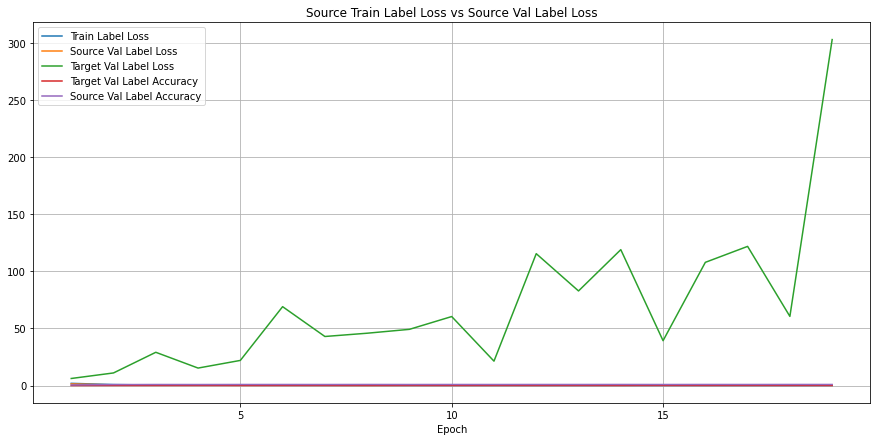

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

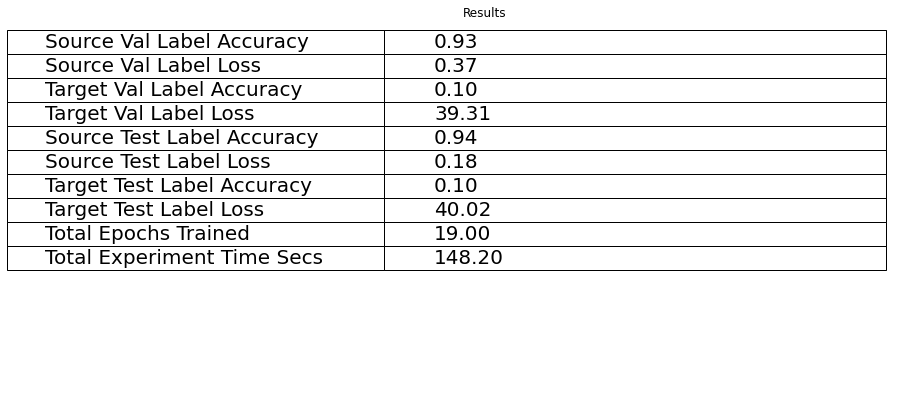

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

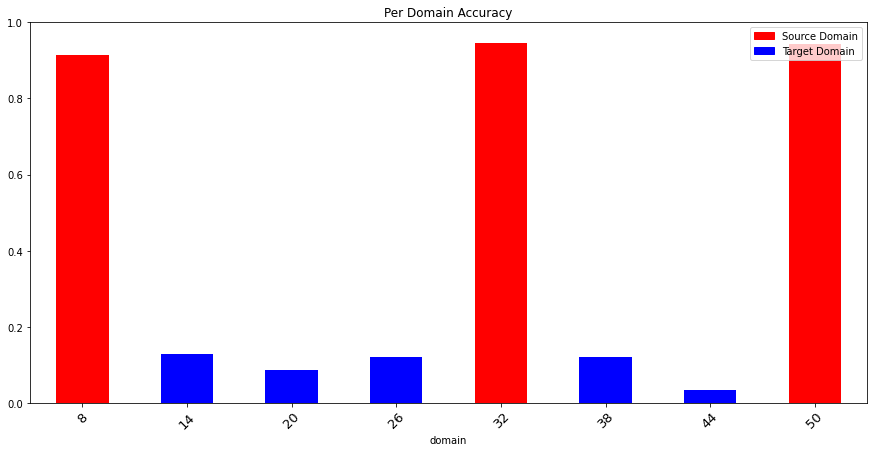

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9372916666666666 Target Test Label Accuracy: 0.09608333333333334
Source Val Label Accuracy: 0.933125 Target Val Label Accuracy: 0.098


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:oracle.run2.framed", "parameters": {"experiment_name": "cnn_1:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1